In [ ]:
%pip install pandas seaborn geopandas bokeh jupyter_bokeh xyzservices h3pandas

### Heatmap of Biodiversity - Hexgrid

Using a hex grid as this more realistically illustrates species locations.

Each hex can represent a plot, biodiversity can be calculated from the points in each hex.

Hexes are placed irrespective of state/county boundaries, giving a more realistic view of biodiversity in the USA

#### References
- https://h3-pandas.readthedocs.io/en/latest/

- https://h3geo.org/docs/core-library/restable/#cell-areas

- https://python.plainenglish.io/creating-beautiful-hexagon-maps-with-python-25c9291eeeda

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import h3pandas
import seaborn as sns
import matplotlib.pyplot as plt
import xyzservices.providers as xyz
from pathlib import Path

from bokeh.palettes import Reds256
from bokeh.io import output_notebook
from bokeh.plotting import output_file, save, figure, show
from bokeh.models import TabPanel, Tabs
from bokeh.models import HoverTool, RangeSlider, CustomJS, RadioButtonGroup
from bokeh.models import GeoJSONDataSource
from bokeh.models import LinearColorMapper, ColorBar

Using the Simpson Diversity Index formula where 0 represents no diversity and 1 represents infinite diversity:

$D = 1 - \sum^R_{i=1} (\dfrac {n_i(n_i-1)}{N(N-1)})$

Formula sourced from: [Libretexts](https://stats.libretexts.org/Bookshelves/Applied_Statistics/Natural_Resources_Biometrics_(Kiernan)/10%3A_Quantitative_Measures_of_Diversity_Site_Similarity_and_Habitat_Suitability/10.01%3A_Introduction__Simpsons_Index_and_Shannon-Weiner_Index#title)

In [4]:
def simpson_diversity(df: pd.DataFrame, spec_col: str, count_col: str) -> float:
  sum = 0
  total_individuals = df[count_col].sum()

  if total_individuals == 1:
    return 0 # Only one species exists, no diversity

  for _, species, count in df.itertuples():
    sum += ((count) * (count - 1)) / (total_individuals * (total_individuals - 1))

  return 1 - sum

Using the Shannon-Wiener Diversity Index

$H' = \frac {N ln \ N -\sum (n_i ln \ n_i)}{N}$

Formula sourced from: [Libretexts](https://stats.libretexts.org/Bookshelves/Applied_Statistics/Natural_Resources_Biometrics_(Kiernan)/10%3A_Quantitative_Measures_of_Diversity_Site_Similarity_and_Habitat_Suitability/10.01%3A_Introduction__Simpsons_Index_and_Shannon-Weiner_Index#title)

In [5]:
def shannon_diversity(df: pd.DataFrame, spec_col: str, count_col: str) -> float:
  sum = 0
  total_individuals = df[count_col].sum()
  for _, species, count in df.itertuples():
    sum += count * np.log(count)

  return ((total_individuals * np.log(total_individuals)) - (sum)) / total_individuals

Test Diversity Index functions

In [6]:
test_df = pd.DataFrame({
  'Species': ['Sugar Maple', 'Beech', 'Yellow Birch'],
  'No. of individuals': [35, 19, 11]
})

# This should output something close to 0.6053
print(simpson_diversity(test_df, 'Species', 'No. of individuals'))

# This should output soomething close to 0.993
print(shannon_diversity(test_df, 'Species', 'No. of individuals'))

0.6052884615384615
0.9934892582483463


<Axes: >

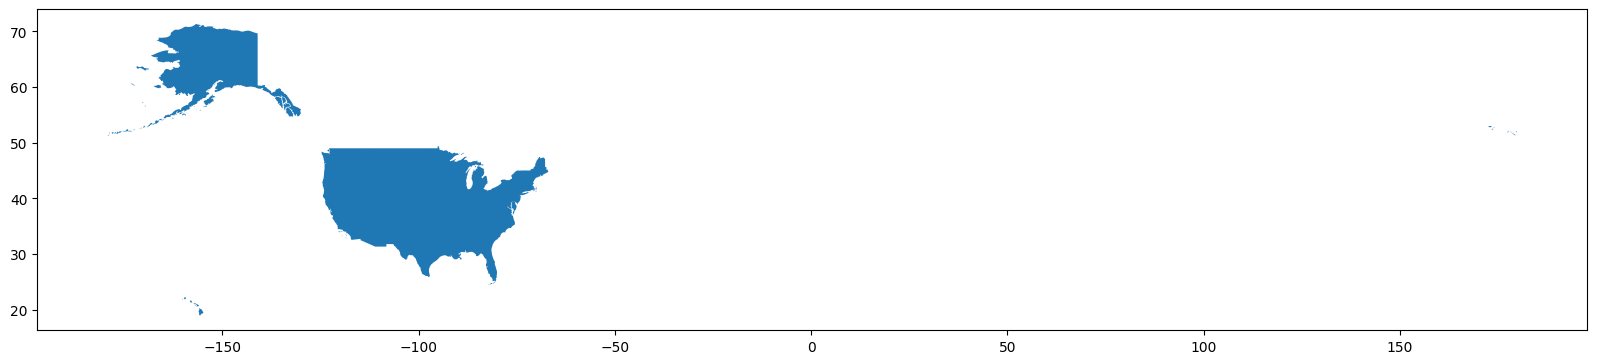

In [7]:
# Import occurrences shapefile

occurrence_gdf = gpd.read_file(Path('../output/occurrences/occurrences.shp'))

# Create a national shape of the United States with just the 50 states

state_shp = gpd.read_file(Path('../dataset/cb_2023_us_all_20m/cb_2023_us_state_20m/cb_2023_us_state_20m.shp'))

exclude = ['American Samoa', 'Commonwealth of the Northern Mariana Islands', 'Puerto Rico', 'United States Virgin Islands', 'Guam']

state_shp = state_shp[~state_shp['NAME'].isin(exclude)]

united_states_shp = state_shp.dissolve()
state_shp = None

united_states_shp.plot(figsize=(20,20))

In [7]:
# Drop unecessary columns

united_states_shp = united_states_shp.drop(columns=['STATEFP', 'STATENS', 'STUSPS', 'LSAD', 'ALAND', 'AWATER', 'GEOIDFQ', 'GEOID', 'NAME'])
united_states_shp

geometry
0  MULTIPOLYGON (((-156.8903 20.74486, -156.90908...

In [8]:
# Calculate the Simpson and Shannon-Weiner biodiversity for a given `year` for each given `plots` using an `occurrences` dataframe
def plot_biodiversity(plots: gpd.GeoDataFrame, occurrences: gpd.GeoDataFrame, year: int) -> gpd.GeoDataFrame:
  data = {
    f'{year}_simpson': [],
    f'{year}_shannon': []
  }

  year_occurrences = occurrences[occurrences['year'] == year]
  
  for row in plots.itertuples():
    county_occurrences = year_occurrences[row.geometry.contains(year_occurrences['geometry'])]
    if len(county_occurrences) == 0:
      data[f'{year}_simpson'].append(pd.NA)
      data[f'{year}_shannon'].append(pd.NA)
    else:
      data[f'{year}_simpson'].append(
        simpson_diversity(county_occurrences['verbatName'].value_counts().reset_index(), 'verbatName', 'count')
      )
      data[f'{year}_shannon'].append(
        shannon_diversity(county_occurrences['verbatName'].value_counts().reset_index(), 'verbatName', 'count')
      )

  plots[f'{year}_simpson'] = data[f'{year}_simpson']
  plots[f'{year}_shannon'] = data[f'{year}_shannon']

  return plots

#### H3 Resolutions

- 3: Cell Size = 12,393.435 km^2, about 4,785.132 mi^2
- 4: Cell Size = 1,770.348 km^2, about 516.151 mi^2
- 5: Cell Size = 252.904 km^2, about 73.735 mi^2
- 6: Cell Size = 36.129 km^2, about 10.534 mi^2
- 7: Cell Size = 5.161 km^2, about 1.505 mi^2

In [14]:
# Produce dataframes for the chart

hex_plots = []
years = sorted(occurrence_gdf['year'].unique())
default_years = (2020, 2024)

# If the data files exist on disk, load them
for i in range(0, 16): # H3 resolutions are between 0 and 15
  try:
    hex_plot = gpd.read_file(Path(f'../output/hex_grids/hex_plot_{i}.geojson')).replace({'<NA>': np.nan}) # TODO: Use this in our other charts where we import files
    
    # Convert columns to numeric types if possible
    for column in hex_plot.columns:
      try:
        hex_plot[column] = pd.to_numeric(hex_plot[column])
      except:
        None

    #hex_plots.append(hex_plot.fillna(value=np.nan))
    hex_plots.append(hex_plot)
  except:
    None # File likely does not exist, do nothing

# Otherwise, regenerate the hex grids (This will take a long time; consider using lower resolutions)
if len(hex_plots) == 0:
  united_states_shp = united_states_shp.to_crs(crs='EPSG:4326') # H3 expects WGS84/EPSG:4326 data

  # Only go up to a resolution of 5, as any more detailed and our computations will slow considerably
  plots = [
    united_states_shp.h3.polyfill_resample(3),
    united_states_shp.h3.polyfill_resample(4),
    united_states_shp.h3.polyfill_resample(5),
  ]

  for i, hex_plot in enumerate(plots):
    print(f'Resolution is: {3 + i}')
    for year in years:
      print(f'\tYear is: {year}')
      plots[i] = plot_biodiversity(hex_plot, occurrence_gdf, year)

  # Create default data for the first draw of the Bokeh plot

  # Default resolution will be the first item in the hex_plots array
  # However, use this to create the average biodiversity columns in each item

  filter_simpson_years = []
  for year in range(default_years[0], default_years[1] + 1):
    if year in years:
      filter_simpson_years.append(f'{year}_simpson')

  filter_shannon_years = []
  for year in range(default_years[0], default_years[1] + 1):
    if year in years:
      filter_shannon_years.append(f'{year}_shannon')

  for hex_plot in plots:
    hex_plot['simpson_biodiversity'] = hex_plot[filter_simpson_years].mean(axis=1)
    hex_plot['shannon_biodiversity'] = hex_plot[filter_shannon_years].mean(axis=1)

  # Drop rows where there is no data

  subset_columns = []
  for year in years:
    subset_columns.append(f'{year}_simpson')
    subset_columns.append(f'{year}_shannon')

  # If all of the biodiversity columns for a row are null, there is no data
  # so, remove the row
  for i, hex_plot in enumerate(plots):
    plots[i] = hex_plot.dropna(subset=subset_columns, how='all')

  # Remove unecessary columns, generate an ID for each hex cell, and save to files

  for i, hex_plot in enumerate(plots):
    resolution = hex_plot.h3.h3_get_resolution()['h3_resolution'].unique()[0]
    plots[i] = hex_plot.drop(columns=['index'])

    total = len(hex_plot)
    ids = []
    for j in range(total):
      ids.append(f'{resolution}-{j:05}')

    plots[i]['id'] = ids

    plots[i].to_file(Path(f'../output/hex_grids/hex_plot_{resolution}.geojson'), driver='GeoJSON')

  hex_plots = plots

In [11]:
output_notebook()

Loading BokehJS ...

In [15]:
# Plot the chart using Bokeh

from bokeh.layouts import layout

palette = list(reversed(Reds256)) # light for low values, dark for high values
for i, hex_plot in enumerate(hex_plots):
    patch_colors = []
    alphas = []
    for _, row in hex_plot.iterrows():
        try:
            index = int(row['simpson_biodiversity'] * 255)
            patch_colors.append(palette[index])
            alphas.append(0.7)
        except ValueError: # Value is NaN
            patch_colors.append("black")
            alphas.append(0)

    hex_plots[i]['color'] = patch_colors
    hex_plots[i]['alpha'] = alphas

# Uncomment to set the colors to Shannon-Weiner on the first draw
# for i, hex_plot in enumerate(hex_plots):
#     patch_colors = []
#     alphas = []

#     shannon_max = hex_plots[0]['shannon_biodiversity'].max()
#     for _, row in hex_plots[0].iterrows():
#         try:
#             proportion = row['shannon_biodiversity'] / shannon_max
#             index = int(proportion * 7)
#             patch_colors.append(palette[index])
#             alphas.append(0.7)
#         except ValueError: # Value is NaN
#             patch_colors.append("black")
#             alphas.append(0)
    
#     hex_plots[i]['color'] = patch_colors
#     hex_plots[i]['alpha'] = alphas

color_mapper = LinearColorMapper(palette=list(reversed(Reds256)))
color_bar = ColorBar(
    color_mapper=color_mapper, 
    padding=5, 
    bar_line_color='black', 
    title='Increasing Biodiversity ------->',
)

sources = []
plots = []
tabs = []

for i, hex_plot in enumerate(hex_plots):
    resolution = hex_plot['id'].unique()[0][0]

    # Reproject `hexplots_4r` to use the Web Mercator CRS (EPSG 3857)
    # This allows tiling and prevents Alaska's Aleutian Islands from being cut off
    source = GeoJSONDataSource(geojson=hex_plot.to_crs(crs='EPSG:3857').to_json())

    p = figure(
        title="Heatmap of USA Biodiversity", 
        x_axis_type="mercator", 
        y_axis_type="mercator",
        toolbar_location='left',
        width=800,
        height=800,
    )
    p.patches('xs', 'ys', source=source, fill_color='color', fill_alpha='alpha', line_color = 'color', line_width = 0)
    p.add_layout(color_bar, 'right')
    p.add_tools(HoverTool(tooltips=[
        ("ID", "@id"),
        ("Simpson Index", "@simpson_biodiversity"),
        ("Shannon-Wiener Index", "@shannon_biodiversity"),
    ], point_policy="follow_mouse"))
    
    p.add_tile(xyz.OpenStreetMap.Mapnik)
    p.match_aspect = True

    sources.append(source)
    plots.append(p)
    tabs.append(TabPanel(child=p, title=f'Resolution {resolution}'))

range_js = """
    var data = source[panels.active].data;
    var palette = palette;

    // cb_obj.value[0] // Start Year

    // cb_obj.value[1] // End Year

    var years = [];

    // Get valid years between the range values
    for (var i = 0; i <= cb_obj.value[1] - cb_obj.value[0]; i++) {
        let year = cb_obj.value[0] + i;

        // We only need to check this for one index
        if (`${year}_simpson` in data) {
            years.push(year);
        }
    }

    // Recalculate biodiversity (Get mean of all valid years)
    // Other indices have the same length as the array used here
    for (var i = 0; i < data.simpson_biodiversity.length; i++) {
        // Get average of values for this row
        let simpson = 0;
        let shannon = 0;

        let valid_simpson_count = 0;
        let valid_shannon_count = 0;

        for (var j = 0; j < years.length; j++) {
            let year = years[j];

            if (!isNaN(data[`${year}_simpson`][i])) {
                simpson += data[`${year}_simpson`][i];
                valid_simpson_count += 1;
            }
            if (!isNaN(data[`${year}_shannon`][i])) {
                shannon += data[`${year}_shannon`][i];
                valid_shannon_count += 1;
            }
        }

        data.simpson_biodiversity[i] = simpson / valid_simpson_count;
        data.shannon_biodiversity[i] = shannon / valid_shannon_count;
    }

    // Update patch colors

    // Simpson Index
    if (btn.active == 0) {
        // Update Colors

        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.simpson_biodiversity[i])) {
                data.color[i] = palette[0];
                data.alpha[i] = 0;
            }
            else {
                data.color[i] = palette[Math.floor(data.simpson_biodiversity[i] * 255)];
                data.alpha[i] = 0.7;
            }
        }
    }

    // Shannon-Wiener Index
    if (btn.active == 1) {
        // Update Colors
        
        // Get max Shannon-Wiener Index value
        let shannon_max = 0

        for (var i = 0; i < data.shannon_biodiversity.length; i++) {
            if (!isNaN(data.shannon_biodiversity[i])) {
                if (data.shannon_biodiversity[i] > shannon_max) {
                    shannon_max = data.shannon_biodiversity[i]
                }
            }
        }
        
        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.shannon_biodiversity[i])) {
                data.color[i] = palette[0];
                data.alpha[i] = 0;
            }
            else {
                let proportion = data.shannon_biodiversity[i] / shannon_max
                data.color[i] = palette[Math.floor(proportion * 255)];
                data.alpha[i] = 0.7;
            }
        }
    }

    source[panels.active].change.emit();
"""

button_js = """
    var data = source[panels.active].data;
    var palette = palette;

    // Simpson Index
    if (btn.active == 0) {
        // Update Colors

        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.simpson_biodiversity[i])) {
                data.color[i] = palette[0];
            }
            else {
                data.color[i] = palette[Math.floor(data.simpson_biodiversity[i] * 255)];
            }
        }
    }

    // Shannon-Wiener Index
    if (btn.active == 1) {
        // Update Colors
        
        // Get max Shannon-Wiener Index value
        let shannon_max = 0

        for (var i = 0; i < data.shannon_biodiversity.length; i++) {
            if (!isNaN(data.shannon_biodiversity[i])) {
                if (data.shannon_biodiversity[i] > shannon_max) {
                    shannon_max = data.shannon_biodiversity[i]
                }
            }
        }
        
        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.shannon_biodiversity[i])) {
                data.color[i] = palette[0];
            }
            else {
                let proportion = data.shannon_biodiversity[i] / shannon_max
                data.color[i] = palette[Math.floor(proportion * 255)];
            }
        }
    }

    source[panels.active].change.emit();
"""

panels = Tabs(tabs=tabs)

labels = ['Simpson Index', 'Shannon-Wiener Index']

radio_buttons = RadioButtonGroup(labels=labels, active=0)

range_slider = RangeSlider(title="Years", start=years[0], end=years[-1], value=default_years, step=1)

range_slider.js_on_change('value', CustomJS(args=dict(source=sources, palette=palette, btn=radio_buttons, panels=panels), code = range_js))

radio_buttons.js_on_event('button_click', CustomJS(args=dict(source=sources, palette=palette, btn=radio_buttons, panels=panels), code=button_js))

layout = layout(
    [range_slider, radio_buttons],
    [panels]
)

show(layout)

In [ ]:
# Save plot to a file
output_file(filename=Path('../charts/biodiversity_heatmap.html'), title='Heatmap of USA Biodiversity')
save(layout)